# Enrichment Analysis on LCI Predictions

Analyzes the enrichment of proteins predicted by LCI

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import json
import pickle

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy


from milieu.paper.methods.lci.lci_method import LCIModule
from milieu.paper.experiments.go_enrichment import GOEnrichment
from milieu.data.network import Network
from milieu.data.go import load_go_annotations
from milieu.util.util import Params, prepare_sns, load_mapping
from milieu.data.associations import load_diseases
os.chdir("/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction")
#os.chdir("/dfs/scratch0/sabri/disease-protein-prediction")
prepare_sns(sns, {})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Loading Data
Load disease associations and protein-protein interaction network.

In [2]:
# load diseases
diseases_dict = load_diseases("data/associations/disgenet-associations.csv", exclude_splits=['none'])

In [3]:
# load network
network = Network("data/networks/species_9606/bio-pathways/network.txt")
n = len(network)

In [6]:
# load entrez mapping
symbol_to_entrez = load_mapping("data/protein/symbol_to_entrez.txt", "\t")
entrez_to_symbol = {int(entrez): symbol for symbol, entrez in symbol_to_entrez.items() if entrez!=""}

### Load Predictions
Load predictions from a disease protein prediction method.

In [7]:
preds_df = pd.read_csv("experiments/dpp_predict/lci/predictions.csv", index_col=0)

### Load Evaluation

In [8]:
eval_df = pd.read_csv("experiments/aggregation/results.csv", header=[0, 1], index_col=0)

### Load Enrichment Analysis
Prepare an enrichment study

In [9]:
# load gene ontology
obodag = GODag("data/go/go-basic.obo")

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms


In [10]:
geneid2go = read_ncbi_gene2go("data/go/gene2go.txt", taxids=[9606])

  20,385 items READ: data/go/gene2go.txt


In [11]:
goeaobj = GOEnrichmentStudy(network.get_names(), # List of mouse protein-coding genes
                            geneid2go, # geneid/GO associations
                            obodag, # Ontologies
                            propagate_counts = True,
                            alpha = 0.05, # default significance cut-off
                            methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 76% 16,420 of 21,557 population items found in association


## Perform Enrichment Analysis
Perform an enrichment analysis on one disease. 

In [21]:
disease_id = "C0001627"
disease_proteins = set(diseases_dict[disease_id].proteins)
disease_symbols = [entrez_to_symbol[entrez] for entrez in disease_proteins if entrez in entrez_to_symbol]
symbols_str=str(disease_symbols).replace('\'', '')
print(f"{diseases_dict[disease_id].name}: {symbols_str}")
sorted_predictions = preds_df.loc[disease_id].sort_values(ascending=False).index
print_list([entrez_to_symbol[int(entrez)] for entrez in sorted_predictions[:7] if int(entrez) in entrez_to_symbol])

Congenital adrenal hyperplasia: [HTR4, PRKAR1A, POR, AVPR1A, AVPR2, PDE8B, CYP11B1, CYP17A1, STAR, HSD3B2, CYP21A2]
(1) AVPR1B, (2) CYP11B2, (3) OXTR, (4) CYP11A1, (5) ZNF653, (6) AVP


In [22]:
# run disease enrichment
disease_results = goeaobj.run_study(disease_proteins)

100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
     936 GO terms are associated with     11 of     11 study items
      85 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [23]:
# run prediction enrichment
pred_proteins = set(map(int, sorted_predictions[:len(disease_proteins)]))
pred_results = goeaobj.run_study(pred_proteins)

 91%     10 of     11 study items found in association
100%     11 of     11 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
     769 GO terms are associated with     10 of     11 study items
      27 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [24]:
def print_list(term_list):
    string = ""
    for i, term in enumerate(term_list):
        string += f"({i+1}) {term}, "
    print(string[:-2])

In [25]:
k = 5
disease_top_k = sorted(disease_results, key=lambda x: x.p_fdr_bh)[:k]
disease_significant = [r for r in disease_results if r.p_fdr_bh < 0.05]
print_list([result.goterm.name for result in disease_top_k])
pred_top_k = sorted(pred_results, key=lambda x: x.p_fdr_bh)[:k]
pred_significant = [r for r in pred_results if r.p_fdr_bh < 0.05]
print_list([result.goterm.name for result in pred_top_k])

(1) glucocorticoid metabolic process, (2) glucocorticoid biosynthetic process, (3) hormone biosynthetic process, (4) C21-steroid hormone metabolic process, (5) cellular hormone metabolic process
(1) regulation of systemic arterial blood pressure by hormone, (2) endocrine process, (3) regulation of systemic arterial blood pressure mediated by a chemical signal, (4) positive regulation of vasoconstriction, (5) positive regulation of blood pressure


In [26]:
intersection = set([result.goterm.name for result in disease_top_k]) & set([result.goterm.name for result in pred_top_k])
union = set([result.goterm.name for result in disease_top_k]) | set([result.goterm.name for result in pred_top_k])
print("Jaccard Similarity: {}".format(1.0*len(intersection)/len(union)))

Jaccard Similarity: 0.0


In [27]:
intersection = set([result.goterm.name for result in pred_significant]) & set([result.goterm.name for result in disease_significant])
union = set([result.goterm.name for result in pred_significant]) | set([result.goterm.name for result in disease_significant])

print("Jaccard Similarity: {}".format(1.0*len(intersection)/len(union)))

Jaccard Similarity: 0.15463917525773196


## Analyze Enrichment Results
Load enrichment study results

### Load Enrichment Results

In [11]:
experiment_dir = 'experiments/go_enrichment/precompute'

In [12]:
outputs_path = os.path.join(experiment_dir, "outputs.pkl")
if os.path.exists(outputs_path):
    with open(outputs_path, 'rb') as f:
        outputs = pickle.load(f)

### Jaccard

In [14]:
def get_significant_terms(output, threshold=0.05):
    """
    """
    terms, pvalues = list(zip(*output.items()))
    significant_idxs = np.where(np.array(pvalues) < threshold)
    return np.array(terms)[significant_idxs]

In [15]:
def jaccard(a_terms, b_terms):
    """
    """
    a_terms = set(a_terms)
    b_terms = set(b_terms)
    return (len(a_terms & b_terms) / len(a_terms | b_terms) if len(a_terms | b_terms) != 0 else 0)

In [19]:
output = outputs["C0013182"]

jaccard_results = {}
for disease_id, output in tqdm(outputs.items()):
    disease_terms = get_significant_terms(output["disease"], threshold=0.01)
    lci_terms = get_significant_terms(output["lci"], threshold=0.01)
    rw_terms = get_significant_terms(output["random_walk"], threshold=0.01)
    lci_jaccard = jaccard(disease_terms, lci_terms)
    rw_jaccard = jaccard(disease_terms, rw_terms)
    jaccard_results[disease_id] = {
        "lci": lci_jaccard,
        "rw": rw_jaccard
    }

In [21]:
jaccard_df = pd.DataFrame(list(jaccard_results.values()), index=list(jaccard_results.keys()))

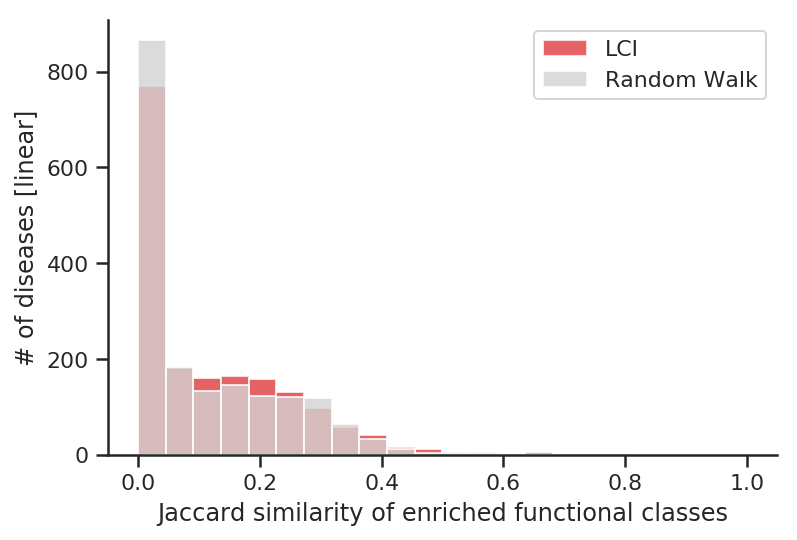

In [22]:
sns.distplot(jaccard_df["lci"], bins=22, kde=False, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(jaccard_df["rw"], bins=22, kde=False, label="Random Walk", hist_kws={"range": (0, 1),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel("Jaccard similarity of enriched functional classes")
plt.ylabel("# of diseases [linear]")
plt.legend()

### Spearman

In [89]:
from scipy.stats import spearmanr
 
def compute_spearman_correlation(a_term_to_pval, b_term_to_pval, terms=None):
        """
        """
        if terms is None:
            terms = list(a_term_to_pval.keys())
        print(len([a_term_to_pval[term] for term in terms]))
        print(len([b_term_to_pval[term] for term in terms]))
        print(np.max([a_term_to_pval[term] for term in terms]))

        sp_corr, sp_pval = spearmanr([a_term_to_pval[term] for term in terms],
                                     [b_term_to_pval[term] for term in terms])
        return sp_corr, sp_pval

In [90]:
output = outputs["C1849295"]
lci_spearman, _ = compute_spearman_correlation(output["disease"], output["lci"])
a_term_to_pval = output["lci"]
terms = list(a_term_to_pval.keys())
np.max(np.isnan([a_term_to_pval[term] for term in terms]))
lci_spearman

21968
21968
1.0


nan

In [48]:
spearman_results = {}
for disease_id, output in tqdm(outputs.items()):
    lci_spearman, _ = compute_spearman_correlation(output["disease"], output["lci"])
    print(disease_id, ":", lci_spearman)
    rw_spearman, _ = compute_spearman_correlation(output["disease"], output["random_walk"])
    spearman_results[disease_id] = {
        "lci": lci_spearman,
        "rw": rw_spearman
    }

C0013182 : 0.36360633290892563
C0917798 : 0.3061427794693464
C0020295 : 0.14015612031940167
C3714796 : 0.2592817408521119
C1866134 : 0.1806777413134153
C2364082 : 0.4172336371809044
C1276035 : 0.2489811102921693
C0027022 : 0.3545704337678227
C1833225 : 0.10420379190492367
C0206620 : 0.32250209318132983
C0006413 : 0.18540495185692138
C0019158 : 0.2285060156101995
C0003126 : 0.4048158453726664
C0241074 : 0.3678966896098149
C0020459 : 0.2814899870250428
C0020541 : 0.37359924042285453
C0014474 : 0.27826295390218614
C4020838 : 0.2949825518042516
C0221170 : 0.27655009296542443
C3275417 : 0.34888649858049336
C0349204 : 0.3629079179155551
C0007787 : 0.09018549377001489
C0018916 : 0.14519104993530874
C1837485 : 0.15264705639472503
C0007222 : 0.27455165474605464
C2673410 : 0.41698444839511944
C0234182 : 0.2594300082506534
C0023493 : 0.3887464610019395
C0023434 : 0.39515101068274283
C0239946 : 0.36772041030726016
C0013336 : 0.22769362549310304
C0014591 : 0.3924622044543078
C0870082 : 0.3369055150

KeyboardInterrupt: 

In [46]:
spearman_df = pd.DataFrame(list(spearman_results.values()), index=list(spearman_results.keys()))
spearman_df.to_csv("experiments/go_enrichment/spearman.csv")
spearman_df.median()

lci    0.248402
rw     0.228240
dtype: float64

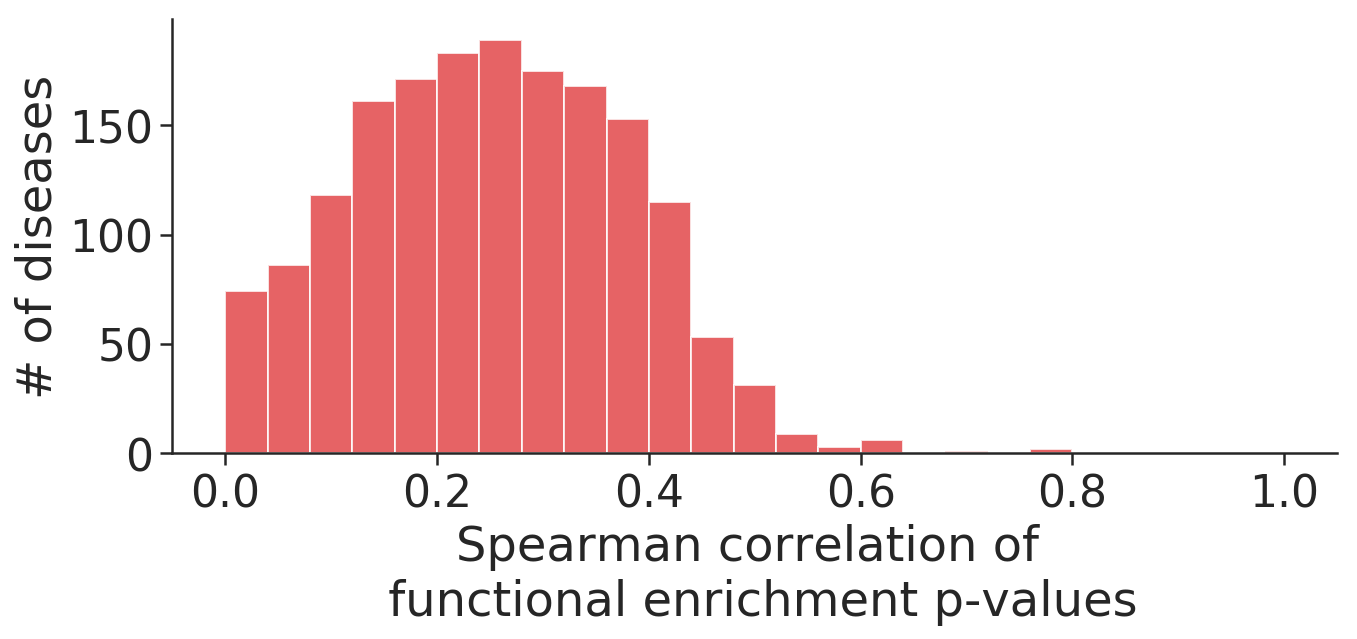

In [45]:
prepare_sns(sns, kwargs={"font_scale": 2,
                         "rc": {'figure.figsize':(10, 5)}})


sns.distplot(spearman_df["lci"], bins=25, kde=False, hist=True, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
#sns.distplot(spearman_df["rw"], bins=25, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0, 1),
#                                                                                      "color": "lightgrey",
#                                                                                      "alpha": 0.8})

plt.yscale('linear')
plt.xlabel("Spearman correlation of \n functional enrichment p-values")
plt.ylabel("# of diseases")
#plt.legend()
sns.despine()
plt.tight_layout()

plt.savefig("experiments/go_enrichment/lci/leci_go.pdf")

#### Top by Mean Correlation

In [18]:
spearman_mean_df = spearman_df[['lci', 'rw']].mean(axis=1)
spearman_df.insert(0, column="mean", value=spearman_mean_df)

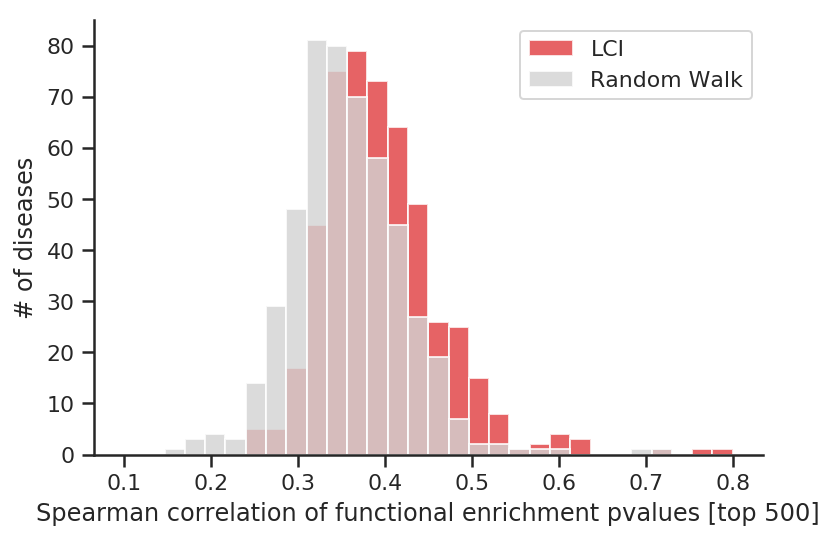

In [21]:
top_k = 500
sns.distplot(spearman_df.nlargest(top_k, "mean")["lci"], bins=30, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "range": (0.1, 0.8),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(spearman_df.nlargest(top_k, "mean")["rw"], bins=30, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0.1, 0.8),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel(f"Spearman correlation of functional enrichment pvalues [top {top_k}]")
plt.ylabel("# of diseases")
plt.legend()
plt.savefig("experiments/go_enrichment/lci/lci_rw_go.pdf")

#### Top by LCI

In [36]:
eval_df["lci_dpp[DP]", "Recall-at-100"]
spearman_df.insert(0, column="lci_recall_100", value=eval_df["lci_dpp[DP]", "Recall-at-100"])

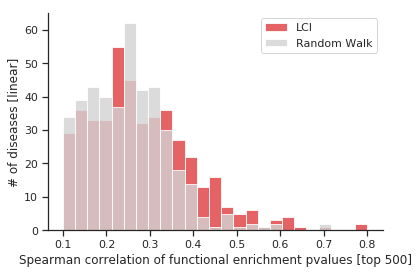

In [44]:
top_k = 500
sns.distplot(spearman_df.nlargest(top_k, "lci_recall_100")["lci"], bins=25, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "range": (0.1, 0.8),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(spearman_df.nlargest(top_k, "lci_recall_100")["rw"], bins=25, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0.1, 0.8),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel(f"Spearman correlation of functional enrichment pvalues [top {top_k}]")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

#### Top by RW

In [38]:
eval_df["lci_dpp[DP]", "Recall-at-100"]
spearman_df.insert(0, column="rw_recall_100", value=eval_df["rw_dpp[DP]", "Recall-at-100"])

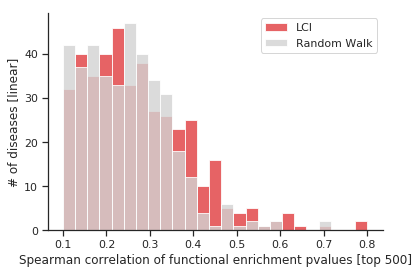

In [45]:
top_k = 500
sns.distplot(spearman_df.nlargest(top_k, "rw_recall_100")["lci"], bins=25, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "range": (0.1, 0.8),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(spearman_df.nlargest(top_k, "rw_recall_100")["rw"], bins=25, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0.1, 0.8),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel(f"Spearman correlation of functional enrichment pvalues [top {top_k}]")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

#### Filter Terms

In [8]:
term_to_proteins = load_go_annotations(network.get_names(), level=None)

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms
  20,385 items READ: data/go/gene2go.txt


In [10]:
def threshold_terms(term_to_proteins, lower, upper):
    """
    Filter terms where the number of proteins does not fall within the 
    lower and upper bounds. 
    """
    return {term: proteins 
            for term, proteins 
            in term_to_proteins.items() 
            if lower <= len(term) <= upper}
    

In [11]:
params = {
    "lower": 20, 
    "upper": 200
}

In [14]:
threshold_terms = threshold_terms(term_to_proteins, **params).keys()

In [19]:
spearman_results = {}
for disease_id, output in tqdm(outputs.items()):
    lci_spearman, _ = compute_spearman_correlation(output["disease"], output["lci"], threshold_terms)
    rw_spearman, _ = compute_spearman_correlation(output["disease"], output["random_walk"], threshold_terms)
    spearman_results[disease_id] = {
        "lci": lci_spearman,
        "rw": rw_spearman
    }

/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-p

In [24]:
threshold_spearman_df = pd.DataFrame(list(spearman_results.values()), index=list(spearman_results.keys()))
threshold_spearman_df.median()

lci    0.267872
rw     0.248970
dtype: float64

In [25]:
threshold_spearman_mean_df = threshold_spearman_df[['lci', 'rw']].mean(axis=1)
threshold_spearman_df.insert(0, column="mean", value=threshold_spearman_mean_df)
threshold_spearman_df

,mean,lci,rw
C0013182,0.380372,0.395963,0.364781
C0917798,0.265945,0.318151,0.213740
C0020295,0.287473,0.160225,0.414721
C3714796,0.284298,0.291277,0.277319
C1866134,0.283801,0.175673,0.391930
C2364082,0.442811,0.457180,0.428442
C1276035,0.177049,0.265299,0.088798
C0027022,0.373263,0.391417,0.355108
C1833225,0.079311,0.125677,0.032944
C0206620,0.351568,0.363231,0.339905


In [1]:
top_k = 500
sns.distplot(threshold_spearman_df.nlargest(top_k, "mean")["lci"], bins=30, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "range": (0.1, 0.8),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(threshold_spearman_df.nlargest(top_k, "mean")["rw"], bins=30, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0.1, 0.8),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel(f"Spearman correlation of functional enrichment pvalues [top {top_k}]")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

NameError: name 'sns' is not defined

### Pearson

In [109]:
from scipy.stats import pearsonr
 
def compute_pearson_correlation(a_term_to_pval, b_term_to_pval):
        """
        """
        terms = list(a_term_to_pval.keys())
        sp_corr, sp_pval = pearsonr([a_term_to_pval[term] for term in terms],
                                    [b_term_to_pval[term] for term in terms])
        return sp_corr, sp_pval

In [110]:
pearson_results = {}
for disease_id, output in tqdm(outputs.items()):
    lci_pearson, _ = compute_pearson_correlation(output["disease"], output["lci"])
    rw_pearson, _ = compute_pearson_correlation(output["disease"], output["random_walk"])
    pearson_results[disease_id] = {
        "lci": lci_pearson,
        "rw": rw_pearson
    }
    

100%|██████████| 1811/1811 [00:58<00:00, 39.14it/s]


In [69]:
pearson_df = pd.DataFrame(list(spearman_results.values()), index=list(spearman_results.keys())).join(size_df)

/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


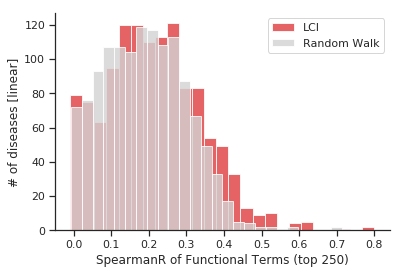

In [80]:
sns.distplot(pearson_df.sort_values('size').head(-500)["lci"], bins=25, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(pearson_df.sort_values('size').head(-500)["rw"], bins=25, kde=False, hist=True, label="Random Walk", hist_kws={
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel("SpearmanR of Functional Terms (top 250)")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

In [117]:
np.mean(pearson_df["lci"])

0.24662556342597527

In [118]:
np.mean(pearson_df["rw"])

0.22427117693116

### Disease Size Analysis

In [39]:
size_dict = {disease.id: len(disease) for disease in diseases_dict.values()}
size_df = pd.DataFrame(size_dict.values(), index=size_dict.keys(), columns=["size"])

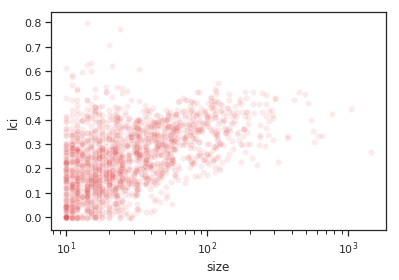

In [119]:
sns.scatterplot(data=spearman_df.join(size_df), x="size", y="lci", alpha=0.1)
plt.xscale('log')